<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-for-Post-Processing-data" data-toc-modified-id="Preprocessing-for-Post-Processing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing for Post-Processing data</a></span><ul class="toc-item"><li><span><a href="#Load-and-preprocess-the-data" data-toc-modified-id="Load-and-preprocess-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load and preprocess the data</a></span></li><li><span><a href="#Split-into-train-and-test-datasets" data-toc-modified-id="Split-into-train-and-test-datasets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Split into train and test datasets</a></span></li></ul></li><li><span><a href="#Preprocessing-for-dataset2" data-toc-modified-id="Preprocessing-for-dataset2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing for dataset2</a></span></li></ul></div>

## Preprocessing for Post-Processing data

The raw data was already interpolated by Sebastian Lerch.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict

In [2]:
RAWDATA = Path('/project/meteo/w2w/C7/ppnn_data/')
AUXDATA = RAWDATA / 'auxiliary/interpolated_to_stations/'
PATH = Path('/local/S.Rasp/ML-Workshop-Data'); PATH.mkdir(exist_ok=True)

In [3]:
# Define aux variable dictionary
aux_dict = OrderedDict()
aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']
aux_dict['data_aux_surface_more_interpolated_part1_00UTC.nc']  = [
    'sshf_fc', 'slhf_fc', 'u10_fc','v10_fc'
]
aux_dict['data_aux_surface_more_interpolated_part2_00UTC.nc']  = [
    'ssr_fc', 'str_fc', 'd2m_fc','sm_fc'
]

### Load and preprocess the data

In [4]:
ds = xr.open_dataset(RAWDATA / 'data_interpolated_00UTC.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:      (member: 50, station: 537, time: 3653)
Coordinates:
  * station      (station) float64 3.0 44.0 71.0 73.0 78.0 91.0 102.0 125.0 ...
  * member       (member) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time         (time) datetime64[ns] 2007-01-03 2007-01-04 2007-01-05 ...
Data variables:
    t2m_fc       (time, member, station) float32 ...
    t2m_obs      (time, station) float32 ...
    station_alt  (station) float32 ...
    station_lat  (station) float32 ...
    station_lon  (station) float32 ...
    station_id   (station) float32 ...
    station_loc  (station) |S36 ...

In [6]:
target = ds['t2m_obs']; target.shape

(3653, 537)

In [7]:
ntime = len(ds.time); ntime
dates = ds['time']
date_array = np.repeat(np.array(dates), len(ds.station)).reshape(-1)

In [9]:
stations = np.tile(np.array(ds.station), len(ds.time)); stations

array([3.0000e+00, 4.4000e+01, 7.1000e+01, ..., 1.5207e+04, 1.5444e+04,
       1.5555e+04])

In [10]:
ds.station

<xarray.DataArray 'station' (station: 537)>
array([3.0000e+00, 4.4000e+01, 7.1000e+01, ..., 1.5207e+04, 1.5444e+04,
       1.5555e+04])
Coordinates:
  * station  (station) float64 3.0 44.0 71.0 73.0 78.0 91.0 102.0 125.0 ...
Attributes:
    units:      station_ID
    long_name:  station

In [11]:
np.unique(stations).shape

(537,)

In [12]:
df = pd.DataFrame(data=np.array(ds['t2m_obs']).reshape(-1), 
                  columns=['t2m_obs'])

In [13]:
df['time'] = date_array
df['station'] = stations.astype('int')
df['t2m_fc_mean'] = np.array(ds['t2m_fc'].mean('member')).reshape(-1)

In [14]:
for aux_fn, var_list in aux_dict.items():
    ds = xr.open_dataset(AUXDATA / aux_fn)
    for var in var_list:
        data = ds[var]
        if 'geo' in aux_fn: 
            df[var] = np.tile(data, ntime)
        else:
            df[var + '_mean'] = np.array(ds[var].mean('member')).reshape(-1)
    ds.close()

In [15]:
df.head()

,t2m_obs,time,station,t2m_fc_mean,orog,station_alt,station_lat,station_lon,u_pl500_fc_mean,v_pl500_fc_mean,...,sp_fc_mean,tcc_fc_mean,sshf_fc_mean,slhf_fc_mean,u10_fc_mean,v10_fc_mean,ssr_fc_mean,str_fc_mean,d2m_fc_mean,sm_fc_mean
0,5.5,2007-01-03,3,3.616448,107.439461,202.0,50.782700,6.0941,10.333423,-27.884222,...,101263.789062,46.793514,9866006.0,-6164262.5,5.054003,-0.848896,1861487.000,-7590969.50,275.956665,318.990753
1,NaN,2007-01-03,44,5.326972,19.397774,44.0,52.933498,8.2370,11.717821,-23.355730,...,101706.960938,50.656349,10608149.0,-6289582.5,5.666816,-2.543470,1745525.000,-8024813.50,275.589539,329.971558
2,NaN,2007-01-03,71,1.330994,604.885010,759.0,48.215599,8.9784,5.802729,-23.275192,...,95306.609375,99.445724,6686426.0,-3214789.5,6.217418,-1.659253,1484513.500,-3518493.75,273.963257,330.582886
3,NaN,2007-01-03,73,0.931550,461.441803,340.0,48.615898,13.0506,9.302703,-15.081739,...,96477.117188,94.537903,10196744.0,-4350500.5,6.793214,-0.926134,1445791.875,-4134411.50,273.610229,320.794128
4,2.9,2007-01-03,78,4.601282,47.632523,65.0,52.485298,7.9126,10.355705,-24.361713,...,101463.531250,48.161633,9816424.0,-6129773.5,5.389324,-1.514338,1738551.375,-7482309.00,275.529633,325.635437


In [16]:
df.to_csv(PATH / 'pp_all.csv', index=False)

### Split into train and test datasets

In [17]:
df_train = df[(df.time >= '2011-01-01') & (df.time < '2016-01-01')]

In [18]:
len(df_train)

980562

In [19]:
df_test = df[(df.time >= '2016-01-01') & (df.time < '2017-01-01')]

In [20]:
df_test.dropna(subset=['t2m_obs'], inplace=True)

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
len(df_test)

182218

In [22]:
df_train.index = range(len(df_train))

In [23]:
df_train.to_csv(PATH / 'pp_train.csv')

In [24]:
df_test.index = range(len(df_test))

In [35]:
df_test.index

RangeIndex(start=0, stop=182218, step=1)

In [36]:
df_solution = pd.DataFrame({'Id': range(len(df_test)), 'Expected': df_test['t2m_obs']})

https://www.kaggle.com/c/postprocessing

In [37]:
df_solution.head()

,Id,Expected
0,0,4.3
1,1,3.3
2,2,-0.8
3,3,3.2
4,4,3.5


In [38]:
df_solution.to_csv(PATH / 'pp_solution.csv', index=False)

In [27]:
df_test.drop('t2m_obs', axis=1).to_csv(PATH / 'pp_test.csv')

In [28]:
!ls -lh $PATH

total 714M
-rw-r--r-- 1 S.Rasp ls-craig 440M Aug 13 11:07 pp_all.csv
-rw-r--r-- 1 S.Rasp ls-craig 4.5M Jul 26 16:23 pp_sample_submission.csv
-rw-r--r-- 1 S.Rasp ls-craig 1.9M Aug 13 11:07 pp_solution.csv
-rw-r--r-- 1 S.Rasp ls-craig  42M Aug 13 11:07 pp_test.csv
-rw-r--r-- 1 S.Rasp ls-craig 226M Aug 13 11:07 pp_train.csv


In [29]:
df_solution.head()

0    4.3
1    3.3
2   -0.8
3    3.2
4    3.5
Name: t2m_obs, dtype: float32

In [42]:
sample = df_solution.copy()

In [43]:
sample.Expected = df_train.t2m_fc_mean.mean()

In [44]:
sample.head()

,Id,Expected
0,0,7.305695
1,1,7.305695
2,2,7.305695
3,3,7.305695
4,4,7.305695


In [45]:
sample.to_csv(PATH / 'pp_sample_submission.csv', index=False)

## Preprocessing for dataset2

In [133]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
DATA_DIR = '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [135]:
fc_lead = np.timedelta64(4*24*60*60+1, 's')
every_10_mins = np.arange('2015-01-01', np.datetime64('2016-10-18T23:50'), 
                          np.timedelta64(10, 'm'), dtype='datetime64[ns]')
dtidx = pd.DatetimeIndex(every_3_hours)

In [136]:
test_months = [[2015, 3], [2015, 5], [2015, 7], [2015, 11], [2016, 3], [2016, 8]]

In [137]:
every_10_mins

array(['2015-01-01T00:00:00.000000000', '2015-01-01T00:10:00.000000000',
       '2015-01-01T00:20:00.000000000', ...,
       '2016-10-18T23:20:00.000000000', '2016-10-18T23:30:00.000000000',
       '2016-10-18T23:40:00.000000000'], dtype='datetime64[ns]')

In [138]:
every_10_mins > np.datetime64('2015-03')

array([False, False, False, ...,  True,  True,  True])

In [139]:
test_times = []
for y, m in test_months:
    b = ((every_10_mins > np.datetime64(f'{y}-{str(m).zfill(2)}')+np.timedelta64(4*24*60*60+1, 's')) & 
         ((every_10_mins < np.datetime64(f'{y}-{str(m+1).zfill(2)}'))))
    test_times.extend(every_10_mins[b])
test_times = np.array(test_times)

In [140]:
train_times = np.setdiff1d(every_10_mins, test_times)

In [141]:
train_times, test_times

(array(['2015-01-01T00:00:00.000000000', '2015-01-01T00:10:00.000000000',
        '2015-01-01T00:20:00.000000000', ...,
        '2016-10-18T23:20:00.000000000', '2016-10-18T23:30:00.000000000',
        '2016-10-18T23:40:00.000000000'], dtype='datetime64[ns]'),
 array(['2015-03-05T00:10:00.000000000', '2015-03-05T00:20:00.000000000',
        '2015-03-05T00:30:00.000000000', ...,
        '2016-08-31T23:30:00.000000000', '2016-08-31T23:40:00.000000000',
        '2016-08-31T23:50:00.000000000'], dtype='datetime64[ns]'))

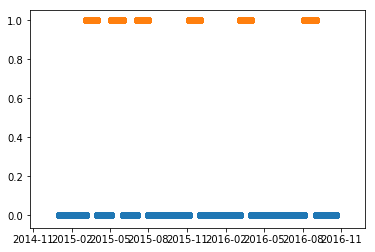

In [142]:
plt.scatter(train_times, np.zeros(train_times.shape))
plt.scatter(test_times, np.ones(test_times.shape))

In [143]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [144]:
POSIX = pwr['epoch_s']
POSIX

<xarray.DataArray 'epoch_s' (epoch_s: 94608)>
array([1420070400, 1420071000, 1420071600, ..., 1476833400, 1476834000,
       1476834600], dtype=int32)
Coordinates:
  * epoch_s  (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...

In [145]:
UTC = pd.to_datetime(pwr.epoch_s, unit='s'); UTC

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 00:10:00',
               '2015-01-01 00:20:00', '2015-01-01 00:30:00',
               '2015-01-01 00:40:00', '2015-01-01 00:50:00',
               '2015-01-01 01:00:00', '2015-01-01 01:10:00',
               '2015-01-01 01:20:00', '2015-01-01 01:30:00',
               ...
               '2016-10-18 22:20:00', '2016-10-18 22:30:00',
               '2016-10-18 22:40:00', '2016-10-18 22:50:00',
               '2016-10-18 23:00:00', '2016-10-18 23:10:00',
               '2016-10-18 23:20:00', '2016-10-18 23:30:00',
               '2016-10-18 23:40:00', '2016-10-18 23:50:00'],
              dtype='datetime64[ns]', length=94608, freq=None)

In [146]:
# Convert to date time
pwr['epoch_s'] = UTC
POSIX['epoch_s'] = UTC

In [147]:
pwr, POSIX

(<xarray.Dataset>
 Dimensions:   (epoch_s: 94608)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...
 Data variables:
     power     (epoch_s) float32 ...
     rawpower  (epoch_s) float32 ...,
 <xarray.DataArray 'epoch_s' (epoch_s: 94608)>
 array([1420070400, 1420071000, 1420071600, ..., 1476833400, 1476834000,
        1476834600], dtype=int32)
 Coordinates:
   * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...)

In [148]:
pwr_train = pwr.sel(epoch_s=train_times)
POSIX_train = POSIX.sel(epoch_s=train_times)

In [149]:
pwr.epoch_s

<xarray.DataArray 'epoch_s' (epoch_s: 94608)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T00:10:00.000000000',
       '2015-01-01T00:20:00.000000000', ..., '2016-10-18T23:30:00.000000000',
       '2016-10-18T23:40:00.000000000', '2016-10-18T23:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...

In [150]:
pwr_train.epoch_s

<xarray.DataArray 'epoch_s' (epoch_s: 71429)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T00:10:00.000000000',
       '2015-01-01T00:20:00.000000000', ..., '2016-10-18T23:20:00.000000000',
       '2016-10-18T23:30:00.000000000', '2016-10-18T23:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...

In [151]:
pwr_train, POSIX_train

(<xarray.Dataset>
 Dimensions:   (epoch_s: 71429)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...
 Data variables:
     power     (epoch_s) float32 ...
     rawpower  (epoch_s) float32 ...,
 <xarray.DataArray 'epoch_s' (epoch_s: 71429)>
 array([1420070400, 1420071000, 1420071600, ..., 1476832800, 1476833400,
        1476834000], dtype=int32)
 Coordinates:
   * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:10:00 ...)

In [152]:
pwr_train['epoch_s'] = POSIX_train

In [153]:
pwr_train

<xarray.Dataset>
Dimensions:   (epoch_s: 71429)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [155]:
pwr_train.to_netcdf(DATA_DIR + 'windpark_train.nc')